In [1]:
# Script for training a denoiser
import os

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/10.1.2'

In [2]:
%load_ext autoreload
%autoreload 2 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from absl import app
from absl import flags
import haiku as hk
import jax
#import optax
import jax.numpy as jnp
import numpy as onp
import pickle
from functools import partial
from jax_lensing.inversion import ks93inv

from flax.metrics import tensorboard

# Import tensorflow for dataset creation and manipulation
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_datasets as tfds

from jax_lensing.inversion import ks93inv, ks93
from jax_lensing.models.convdae2 import MediumUResNet
from jax_lensing.models.convdae import SmallUResNet
from jax_lensing.models.normalization import SNParamsTree as CustomSNParamsTree
from jax_lensing.spectral import measure_power_spectrum, make_power_map
from jax_lensing.utils import load_dataset
from tqdm.notebook import tqdm

from astropy.io import fits

import types
from typing import Mapping, Optional, Sequence, Union

In [4]:
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
from jax_lensing.samplers.score_samplers import ScoreHamiltonianMonteCarlo, ScoreMetropolisAdjustedLangevinAlgorithm
from jax_lensing.samplers.tempered_sampling import TemperedMC

In [5]:
dataset = "kappatng"
weight_dir = "/linkhome/rech/genpuc01/utb76xl/commun/weights/gp-sn1v5"
model_version = 'SmallUResNet'
#model_name = 'MediumUResNet'
batch_size = 32
gaussian_prior = True
gaussian_path = "../data/ktng/ktng_PS_theory.npy"
map_size = 360
resolution = 0.29
train_split = "90%"
noise_dist_std = 0.2
sigma_gamma = 0.148
pixel_size = jnp.pi * resolution / 180. / 60. #rad/pixel

In [6]:
rng_seq = hk.PRNGSequence(42)

In [7]:
def make_power_map(power_spectrum, size, kps=None, zero_freq_val=1e7):
  #Ok we need to make a map of the power spectrum in Fourier space
  k1 = np.fft.fftfreq(size)
  k2 = np.fft.fftfreq(size)
  kcoords = np.meshgrid(k1,k2)
  # Now we can compute the k vector
  k = np.sqrt(kcoords[0]**2 + kcoords[1]**2)
  if kps is None:
    kps = np.linspace(0,0.5,len(power_spectrum))
  # And we can interpolate the PS at these positions
  ps_map = np.interp(k.flatten(), kps, power_spectrum).reshape([size,size])
  ps_map = ps_map
  ps_map[0,0] = zero_freq_val
  return ps_map # Carefull, this is not fftshifted

In [8]:
# load theoretical power spectrum
ps_data_th = onp.load(gaussian_path).astype('float32')

# calibration
ell_th = jnp.array(ps_data_th[0,:])
ps_halofit_th = jnp.array(ps_data_th[1,:] / pixel_size**2)
#kell_th = ell_th / (360/3.5/0.5) / float(map_size)
kell_th = ell_th /2/jnp.pi * 360 * pixel_size / map_size

# Interpolate the Power Spectrum in Fourier Space
power_map_th = jnp.array(make_power_map(ps_halofit_th, map_size, kps=kell_th))

In [9]:
# load convergence maps
train_set = load_dataset(dataset,
                         batch_size,
                         map_size,
                         noise_dist_std,
                         train_split)

dict_keys(['x', 'y', 'u', 's'])


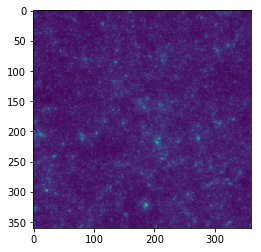

In [10]:
batch = next(train_set)
print(batch.keys())
imshow(batch['x'][0,...,0])

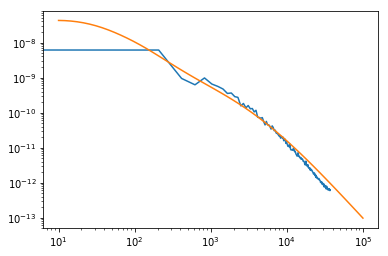

In [11]:
ps_data_th = onp.load(gaussian_path).astype('float32')
ell, power_spectrum_1d = measure_power_spectrum(batch['x'][0,...,0], pixel_size)
ps_data_map = jnp.stack([ell, power_spectrum_1d], axis=0)
loglog(ps_data_map[0,:], ps_data_map[1,:])
loglog(ps_data_th[0,:], ps_data_th[1,:])

In [12]:
def forward(x, s, is_training=False):
    if model_version == 'SmallUResNet':
        denoiser = SmallUResNet(n_output_channels=1, variant='EiffL')
    elif model_version == 'MediumUResNet':
        denoiser = MediumUResNet()
    return denoiser(x, s, is_training=is_training)

model = hk.transform_with_state(forward)

#sn_fn = hk.transform_with_state(lambda x: hk.SNParamsTree(ignore_regex='[^?!.]*b$')(x))
#sn_fn = hk.transform_with_state(lambda x: CustomSNParamsTree(ignore_regex='[^?!.]*b$',val=2.)(x))

In [13]:
# import trained model weights
#model_name = "model-35000.pckl"
model_name = "model-final.pckl"

with open(weight_dir+'/'+ model_name, 'rb') as file: 
    params, state, sn_state = pickle.load(file)

In [14]:
def log_gaussian_prior(map_data, sigma, ps_map):
    data_ft = jnp.fft.fft2(map_data) / float(map_size)
    return -0.5*jnp.sum(jnp.real(data_ft*jnp.conj(data_ft)) / (ps_map+sigma[0]**2))

gaussian_prior_score = jax.vmap(jax.grad(log_gaussian_prior), in_axes=[0,0, None])

In [15]:
def score_fn(params, state, rng_key, batch, is_training=True):
    if gaussian_prior:
        # If requested, first compute the Gaussian prior
        gaussian_score = gaussian_prior_score(batch['y'][...,0], batch['s'][...,0], power_map_th)
        gaussian_score = jnp.expand_dims(gaussian_score, axis=-1)
        net_input = jnp.concatenate([batch['y'], jnp.abs(batch['s'])**2 * gaussian_score],axis=-1)
        res, state = model.apply(params, state, rng_key, net_input, batch['s'], is_training=is_training)
    else:
        res, state = model.apply(params, state, rng_key, batch['y'], batch['s'], is_training=is_training)
        gaussian_score = jnp.zeros_like(res)
    return batch, res, gaussian_score

score_fn = partial(score_fn, params, state, next(rng_seq))

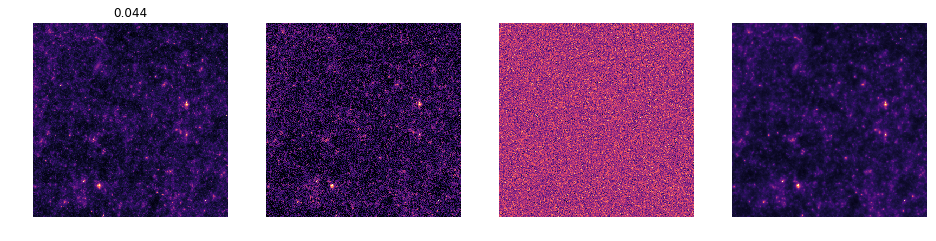

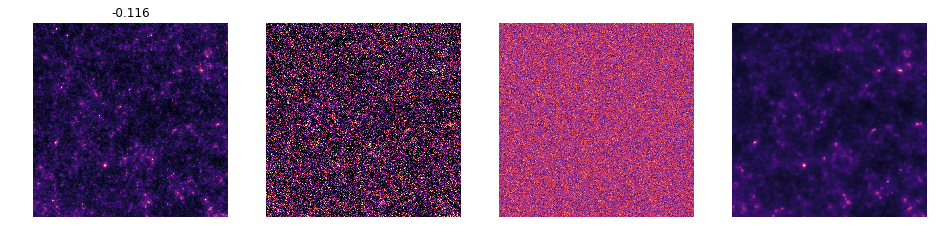

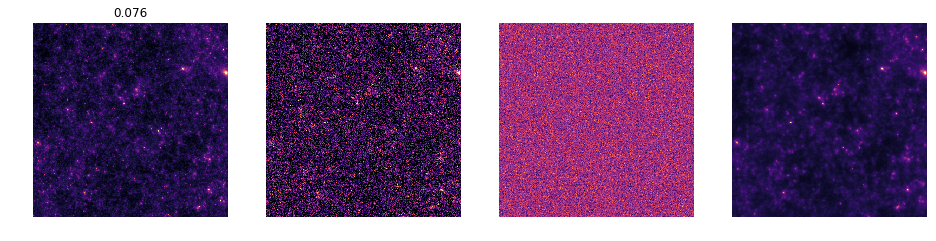

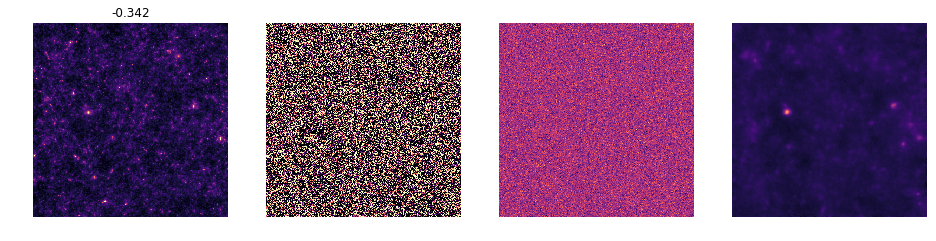

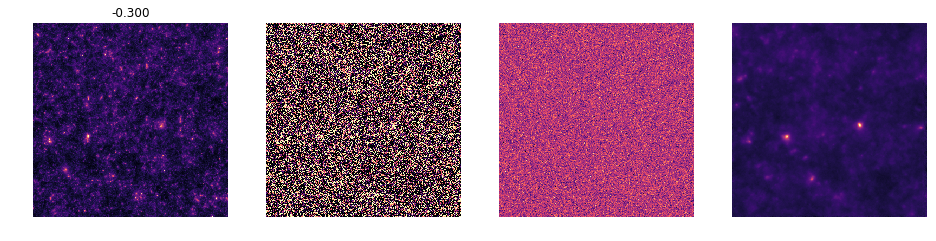

In [16]:
batch = next(train_set)
#res, state = score_fn(batch['x'],batch['s'], is_training=False)
_, res, gaussian_score = score_fn(batch)

for i in range(5):
    ind = i
    figure(figsize=(16,4))
    subplot(141)
    title("%0.3f"%batch['s'][ind,0,0,0])
    imshow(batch['x'][ind,...,0],cmap='magma',vmin=-0.05,vmax=0.3)
    axis('off')
    subplot(142)
    imshow(batch['y'][ind,...,0],cmap='magma',vmin=-0.05,vmax=0.3)
    axis('off')
    subplot(143)
    #imshow(res[ind,...,0],cmap='magma')
    imshow(res[ind,...,0] + gaussian_score[ind,...,0], cmap='magma')
    axis('off')
    #title("%0.3f"%std(batch['s'][ind,:,:,0]**2 * res[ind,...,0]))
    subplot(144)
    #imshow(batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * res[ind,...,0],cmap='magma',vmin=-0.05,vmax=0.3)
    imshow(batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * (res[ind,...,0] + gaussian_score[ind,...,0]),cmap='magma',vmin=-0.05,vmax=0.3)
    #batch['s'] * (res + gaussian_score))**2
    axis('off')

[[-0.11614066]]


(-0.5, 359.5, 359.5, -0.5)

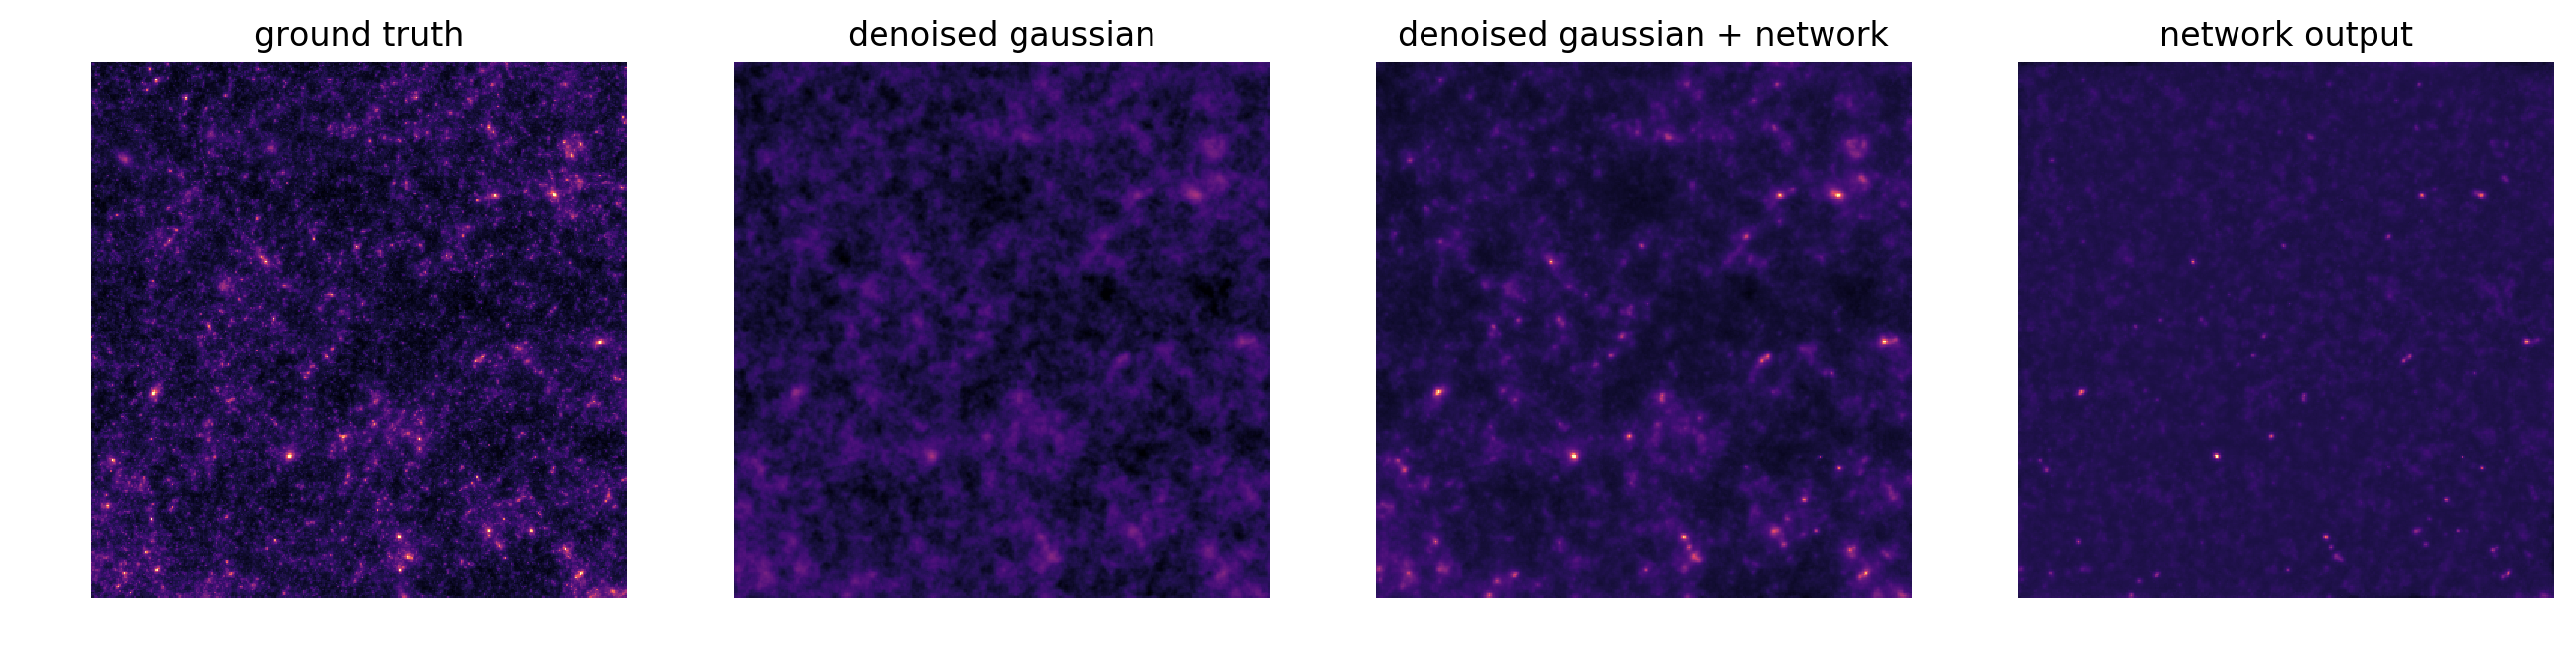

In [17]:
figure(figsize=(16,4), dpi=200)

ind = 1

print(batch['s'][ind,:,:,0])
#style.use('dark_background')
vmax = 0.3

subplot(141)

imshow(batch['x'][ind,...,0],cmap='magma',vmin=-0.05,vmax=vmax)
title('ground truth')
#colorbar()
axis('off')

subplot(142)

imshow(batch['y'][ind,...,0] + (batch['s'][ind,:,:,0]**2) *(gaussian_score[ind,...,0]), cmap='magma', vmin=-0.05,vmax=vmax)
title('denoised gaussian')
axis('off')
#colorbar()

subplot(143)

imshow(batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * (res[ind,...,0] + gaussian_score[ind,...,0]),cmap='magma',vmin=-0.05,vmax=vmax)
title('denoised gaussian + network')
axis('off')
#title("%0.3f"%std(batch['s'][ind,:,:,0]**2 * res[ind,...,0]))
#colorbar()

subplot(144)

imshow((batch['s'][ind,:,:,0]**2) * res[ind,...,0], cmap='magma',vmin=-0.05,vmax=vmax)
title('network output')
axis('off')

#savefig('gauss-res.png')

## Annealed sampling

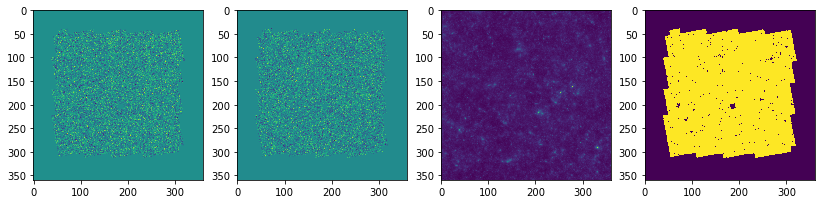

In [18]:
meas_shear = fits.getdata('../data/ktng/ktng_cosmos_e360.fits').astype('float32')
convergence = fits.getdata('../data/ktng/ktng_cosmos_kappa360.fits').astype('float32')
mask = fits.getdata('../data/COSMOS/cosmos_full_mask_0.29arcmin360copy.fits').astype('float32')

#meas_shear = jnp.stack(ks93inv(convergence, jnp.zeros_like(convergence)), axis=-1)

mask = jnp.expand_dims(mask, -1)
masked_true_shear = meas_shear * mask

figure(figsize(14,5))
subplot(141)
imshow(masked_true_shear[..., 0])
subplot(142)
imshow(masked_true_shear[..., 1])
subplot(143)
imshow(convergence)
subplot(144)
imshow(mask[...,0])

In [19]:
def log_likelihood(x, sigma, meas_shear, mask):
    """ Likelihood function at the level of the measured shear
    """
    ke = x.reshape((map_size, map_size))
    kb = jnp.zeros(ke.shape)
    model_shear = jnp.stack(ks93inv(ke, kb), axis=-1)
    #if FLAGS.reduced_shear:
    #    model_shear = model_shear /( 1. - jnp.clip(jnp.expand_dims(ke,axis=-1), -1., 0.9))
    return - jnp.sum(mask*(model_shear - meas_shear)**2/((sigma_gamma)**2 + sigma**2) )/2.

likelihood_score = jax.vmap(jax.grad(log_likelihood), in_axes=[0,0, None, None])

In [20]:
def score_prior(x, sigma):
    net_input = {'y':x.reshape(-1,360, 360,1), 's':sigma.reshape(-1,1,1,1)}
    _, res, gaussian_score = score_fn(net_input)
    return (res[..., 0:1] + gaussian_score).reshape(-1, 360*360)
    #return res[..., 0:1].reshape(-1, 360*360), gaussian_score.reshape(-1, 360*360)

In [21]:
def total_score_fn(x, sigma):
    sl = likelihood_score(x, sigma, meas_shear, mask).reshape(-1, 360*360)
    sp = score_prior(x, sigma)
    return (sl + sp).reshape(-1, 360*360)

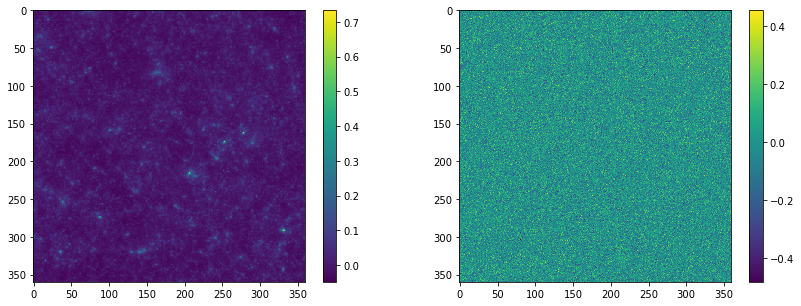

In [22]:
import numpy as onp
kappa_init = onp.random.randn(map_size, map_size) * 0.1
#kappa_init = jnp.expand_dims(kappa_init, axis=0)
sigma = jnp.zeros((1,1,1))

# Initialize with KS93
subplot(121)
imshow(convergence)
colorbar()
subplot(122)
imshow(kappa_init)
colorbar()

kappa_init = jnp.expand_dims(kappa_init, axis=0)

In [23]:
gaussian_prior_score(kappa_init, sigma, power_map_th)

DeviceArray([[[ 1530.7119  ,  -795.6     ,  -289.9633  , ...,
                -510.17636 ,   668.4362  , -1494.8782  ],
              [ -896.1223  ,   277.98026 ,   481.48672 , ...,
                 191.51967 ,   330.00195 ,   317.8791  ],
              [  -43.012024,  -179.92944 ,   -86.181305, ...,
                -396.2907  ,  -591.3158  ,   367.31702 ],
              ...,
              [ -480.09296 ,   462.72958 ,    14.587524, ...,
                -591.74115 ,   670.18494 ,  -389.19086 ],
              [ 1019.40295 ,  -823.2706  ,  -400.315   , ...,
                 419.48672 ,  -601.04333 ,  -324.3114  ],
              [-1115.7827  ,  1055.6117  ,   202.82843 , ...,
                 754.773   ,  -639.1176  ,   869.4313  ]]], dtype=float32)

In [24]:
likelihood_score(kappa_init, sigma, meas_shear, mask).reshape(-1, 360*360).shape

(1, 129600)

In [25]:
score_prior(kappa_init, sigma).shape

(1, 129600)

In [26]:
total_score_fn(kappa_init, sigma).shape

(1, 129600)

In [27]:
#gamma_init = (jnp.repeat(jnp.expand_dims(mask*gamma,0), 1, axis=0) +
#                jnp.expand_dims((1. - mask)*FLAGS.sigma_gamma,0)*onp.random.randn(FLAGS.batch_size, 320, 320, 2))
#gamma = jnp.stack()
#true_shear.shape

In [28]:
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
from jax_lensing.samplers.score_samplers import ScoreHamiltonianMonteCarlo, ScoreMetropolisAdjustedLangevinAlgorithm
from jax_lensing.samplers.tempered_sampling import TemperedMC

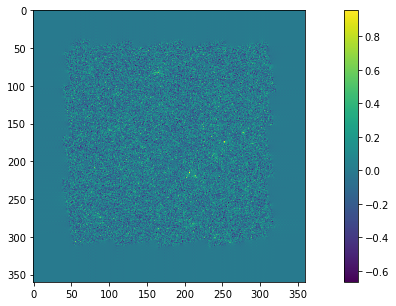

In [29]:
import numpy as onp
#sigma_gamma = 0.15

batch_size = 1
initial_temperature = 0.15
delta_tmp = onp.sqrt(initial_temperature**2 - sigma_gamma**2)
initial_step_size = 0.0012
min_steps_per_temp = 10
#init_image = (delta_tmp*randn(1,360,360)).reshape((-1, 360*360,)).astype('float32')
init_image, _ = ks93(mask[...,0]*meas_shear[...,0], mask[...,0]*meas_shear[...,1])
#init_image += (delta_tmp*randn(1,360,360))
init_image = init_image.reshape((-1, 360*360,)).astype('float32')

init_image = jnp.repeat(init_image, batch_size, axis=0)

imshow(init_image[2,...].reshape(360, 360))
colorbar()

In [30]:
#np.save('./sample1.npy', samples[-1][0,...].reshape(360,360))
sample1 = np.load('./sample1.npy')

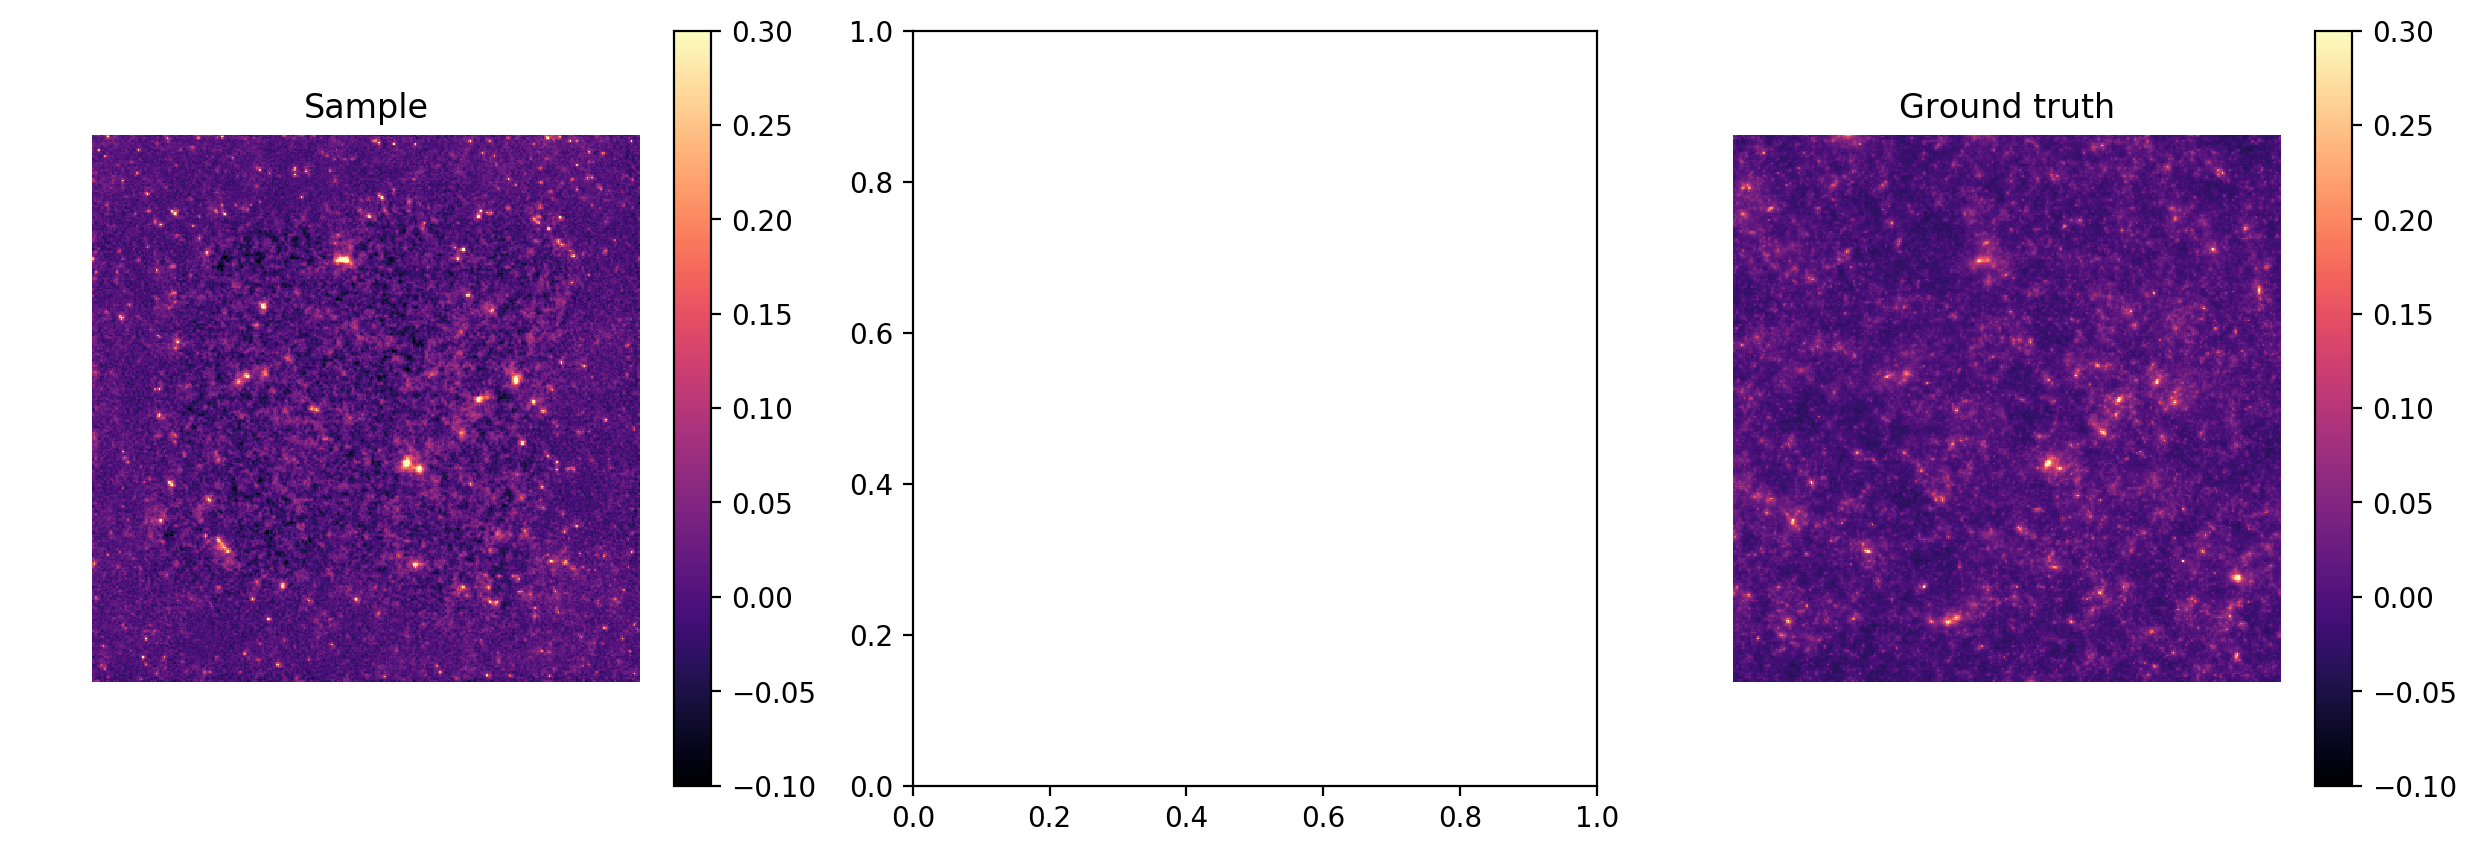

In [31]:
vmin = -0.1
vmax = 0.3

figure(figsize=(15,5), dpi=200)
subplot(131)
title('Sample')
imshow(sample1, cmap='magma', vmin=vmin, vmax=vmax);
axis('off')
colorbar()

subplot(132)
#imshow(batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * (res[ind,...,0] + gaussian_score[ind,...,0]), cmap='magma', vmin=vmin, vmax=vmax)
#title('denoised gaussian + network')


subplot(133)
title('Ground truth')
imshow(convergence, cmap='magma', vmin=vmin, vmax=vmax);
axis('off')
colorbar()

In [ ]:
%%time

initial_step_size = 0.0012

def make_kernel_fn(target_log_prob_fn, target_score_fn, sigma):
  return ScoreHamiltonianMonteCarlo(
      target_log_prob_fn=target_log_prob_fn,
      target_score_fn=target_score_fn,
      step_size=initial_step_size*(jnp.max(sigma)/initial_temperature)**0.5,
      #step_size=10*(np.max(sigma)/s0)**0.5,
      num_leapfrog_steps=3,
      num_delta_logp_steps=4)

tmc = TemperedMC(
            target_score_fn=total_score_fn,#score_prior,
            inverse_temperatures=initial_temperature*np.ones([batch_size]),
            make_kernel_fn=make_kernel_fn,
            gamma=0.98,
            min_steps_per_temp=min_steps_per_temp*10,
            num_delta_logp_steps=4)


num_results = int(6e3)
num_burnin_steps = int(0)

samples2, trace2 = tfp.mcmc.sample_chain(
        #num_results=num_results,
        num_results=2,
        current_state=init_image.reshape([batch_size, -1]),
        kernel=tmc,
        num_burnin_steps=num_burnin_steps,
        #num_steps_between_results=1,
        num_steps_between_results=num_results//2,
        trace_fn=lambda _, pkr: (pkr.pre_tempering_results.is_accepted,
                                 pkr.post_tempering_inverse_temperatures,
                                 pkr.tempering_log_accept_ratio),
        seed=jax.random.PRNGKey(0))

"""
samples, trace = tfp.mcmc.sample_chain(
        num_results=3,
        current_state=init_image.reshape([batch_size, -1]),
        kernel=tmc,
        num_burnin_steps=num_burnin_steps,
        num_steps_between_results=num_results//3,
        trace_fn=lambda _, pkr: (pkr.pre_tempering_results.is_accepted,
                                 pkr.post_tempering_inverse_temperatures,
                                 pkr.tempering_log_accept_ratio),
        seed=jax.random.PRNGKey(0))
"""
print(len(samples))
#######
######

/linkhome/rech/genpuc01/utb76xl/.local/lib/python3.7/site-packages/jax/lax/lax.py:6193: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


[Traced<ShapedArray(float32[1,129600]):JaxprTrace(level=1/0)>]


In [ ]:
figure(figsize=(9,3))
subplot(131)
plot(trace2[0]);
title('acceptance')
subplot(132)
plot(trace2[1]);
title('temp')
subplot(133)
plot(exp(trace2[2]));
title('accept tempering')

In [ ]:
s = samples2[-1,...]
sigma = trace2[1][-1] * jnp.ones(s.shape[0])
batch = {'y':s.reshape(-1,360, 360,1), 's':sigma.reshape(-1,1,1,1)}
_, res, gaussian_score = score_fn(batch)
res.shape

vmin = -0.1
vmax = 0.3

figure(figsize=(15,5), dpi=200)
subplot(131)
title('Sample')
imshow(samples2[-1][0,...].reshape(360,360), cmap='magma', vmin=vmin, vmax=vmax);
axis('off')
colorbar()

subplot(132)
imshow(batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * (res[ind,...,0] + gaussian_score[ind,...,0]), cmap='magma', vmin=vmin, vmax=vmax)
title('denoised gaussian + network')


subplot(133)
title('Ground truth')
imshow(convergence, cmap='magma', vmin=vmin, vmax=vmax);
axis('off')
colorbar()

In [ ]:
print(trace2[1][-1])

In [ ]:
#imshow(mask.reshape(360,360)*samples2[-1,...].reshape(360,360))

In [ ]:
s = samples2[-1,...]
sigma = trace2[1][-1] * jnp.ones(s.shape[0])
batch = {'y':s.reshape(-1,360, 360,1), 's':sigma.reshape(-1,1,1,1)}
_, res, gaussian_score = score_fn(batch)
res.shape

In [ ]:
denoised2 = batch['y'][ind,...,0] + batch['s'][ind,:,:,0]**2 * (res[ind,...,0] + gaussian_score[ind,...,0])

In [ ]:
figure(figsize=(7,5), dpi=100)

ell, ps_gt = measure_power_spectrum(convergence, pixel_size)
ps_data_gt = jnp.stack([ell, ps_gt], axis=0)
loglog(ps_data_gt[0,:], ps_data_gt[1,:], label='ktng ground truth')

ell, ps_sample = measure_power_spectrum(sample1, pixel_size)
ps_data_sample = jnp.stack([ell, ps_sample], axis=0)
loglog(ps_data_sample[0,:], ps_data_sample[1,:], label='1 sample')

ell2, ps_sample2 = measure_power_spectrum(samples2[-1][0,...].reshape(360,360), pixel_size)
ps_data_sample2 = jnp.stack([ell2, ps_sample2], axis=0)
loglog(ps_data_sample2[0,:], ps_data_sample2[1,:], label='1 sample v2')

#ell, ps_mean = measure_power_spectrum(jnp.median(samples[-1], axis=0).reshape(360,360), pixel_size)
#ps_data_mean = jnp.stack([ell, ps_mean], axis=0)
#loglog(ps_data_mean[0,:], ps_data_mean[1,:], label='sample')

ell, ps_denoised = measure_power_spectrum(denoised2.reshape(360,360), pixel_size)
ps_data_denoised = jnp.stack([ell, ps_denoised], axis=0)
loglog(ps_data_denoised[0,:], ps_data_denoised[1,:], label='denoised')


loglog(ps_data_th[0,:], ps_data_th[1,:], label='theoretical')

legend()

In [ ]:
loglog(ps_data_gt[0,:], ps_data_sample[1,:]/ps_data_gt[1,:], label='v1')
loglog(ps_data_gt[0,:], ps_data_sample2[1,:]/ps_data_gt[1,:], label='v2')
loglog(ps_data_gt[0,:], ps_data_denoised[1,:]/ps_data_gt[1,:], label='v2 denoised')
legend()

In [ ]:
#12e3 0.0015
#a = samples[-1][0,...].reshape(360,360)

#8e3 0.0015
#b = samples[-1][0,...].reshape(360,360)

#8e3 0.002
#b = samples[-1][0,...].reshape(360,360)

In [ ]:
#imshow(delta_tmp*onp.random.randn(360, 360))